In [52]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
turismo = pd.read_csv("datos_turistas.txt",sep = "|",decimal=",",encoding="='utf-8")
Municipio =pd.read_excel('Tablas Correlativas.xlsx',sheet_name="Correlativa municipios")
country =pd.read_excel('Tablas Correlativas.xlsx',sheet_name="Correlativa ISO Country")
motivo_viaje =pd.read_excel('Tablas Correlativas.xlsx',sheet_name="Correlativa motivo de viaje")

In [8]:
turismo.head()

,Código ISO país,Código Municipio,Código Motivo de viaje,Género,Mes,Año,Cantidad turistas
0,AFG,'05059,1,F,6,2015,1
1,AFG,'11001,1,F,6,2015,3
2,AFG,'11001,1,M,2,2015,1
3,AFG,'11001,1,M,6,2015,1
4,AFG,'11001,2,M,4,2015,2


In [19]:
country.head()

,Código ISO país,País
0,ABW,Aruba
1,AFG,Afganistán
2,AGO,Angola
3,AIA,Anguila
4,ALB,Albania


In [25]:
df = pd.merge(turismo,Municipio,how="left",left_on="Código Municipio",right_on="CODIGO_MUNICIPIO")

In [26]:
df = pd.merge(df,country,how="left",on="Código ISO país")

In [28]:
df= pd.merge(df,motivo_viaje,how="left",on="Código Motivo de viaje")

In [30]:
df.head()

,Código ISO país,Código Municipio,Código Motivo de viaje,Género,Mes,Año,Cantidad turistas,CODIGO_MUNICIPIO,NOMBRE_DEPTO,PROVINCIA,NOMBRE_MPIO,País,Motivo de viaje
0,AFG,'05059,1,F,6,2015,1,'05059,ANTIOQUIA,OCCIDENTE,ARMENIA,Afganistán,"Vacaciones, recreo y ocio"
1,AFG,'11001,1,F,6,2015,3,'11001,BOGOTÁ D.C.,BOGOTA,BOGOTA D.C.,Afganistán,"Vacaciones, recreo y ocio"
2,AFG,'11001,1,M,2,2015,1,'11001,BOGOTÁ D.C.,BOGOTA,BOGOTA D.C.,Afganistán,"Vacaciones, recreo y ocio"
3,AFG,'11001,1,M,6,2015,1,'11001,BOGOTÁ D.C.,BOGOTA,BOGOTA D.C.,Afganistán,"Vacaciones, recreo y ocio"
4,AFG,'11001,2,M,4,2015,2,'11001,BOGOTÁ D.C.,BOGOTA,BOGOTA D.C.,Afganistán,Negocios y motivos profesionales


In [42]:
df['fecha'] = pd.to_datetime({'year':df['Año'],'month':df['Mes'],'day':1}, format='%Y%m')
# (df.Año.to_string()+df.Mes.to_string())

In [184]:
turistas2023=df[df['Año']==2023]['Cantidad turistas'].sum()
(df[df['Año']==2023][['País','Cantidad turistas']].groupby(['País']).sum().sort_values(by=['Cantidad turistas'],ascending=False).head(4)/turistas2023)

,Cantidad turistas
País,
Estados Unidos,0.287590
Ecuador,0.084373
México,0.079763
Perú,0.051760


In [190]:
df[df['Año']==2023][['País','Cantidad turistas']].groupby(['Motivo de viaje']).sum()

In [46]:
df.head(2)

,Código ISO país,Código Municipio,Código Motivo de viaje,Género,Mes,Año,Cantidad turistas,CODIGO_MUNICIPIO,NOMBRE_DEPTO,PROVINCIA,NOMBRE_MPIO,País,Motivo de viaje,fecha
0,AFG,'05059,1,F,6,2015,1,'05059,ANTIOQUIA,OCCIDENTE,ARMENIA,Afganistán,"Vacaciones, recreo y ocio",2015-06-01
1,AFG,'11001,1,F,6,2015,3,'11001,BOGOTÁ D.C.,BOGOTA,BOGOTA D.C.,Afganistán,"Vacaciones, recreo y ocio",2015-06-01


In [49]:
serie = df[['Cantidad turistas','fecha']].groupby(['fecha']).sum()

In [56]:
serie

,Cantidad turistas
fecha,
2015-01-01,147979
2015-02-01,159601
2015-03-01,163073
2015-04-01,144602
2015-05-01,151341
...,...
2023-04-01,296115
2023-05-01,282254
2023-06-01,312374


In [40]:
sns.set()

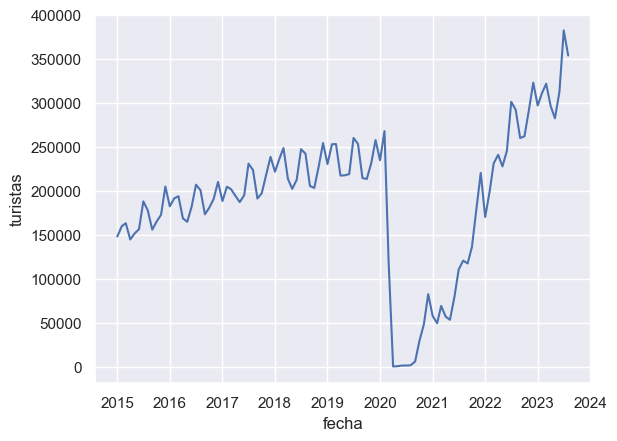

In [53]:
plt.ylabel('turistas')
plt.xlabel('fecha')
plt.plot(serie.index, serie['Cantidad turistas'])

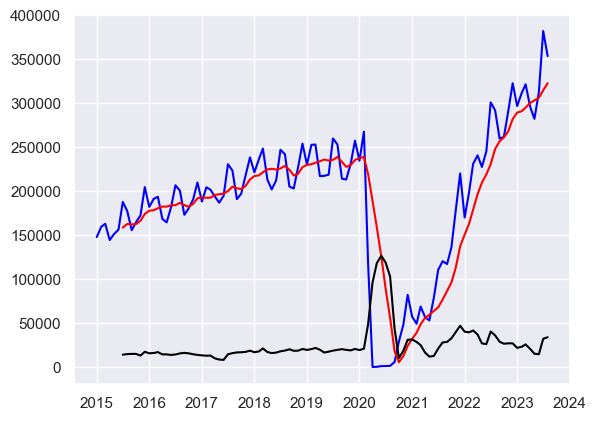

In [54]:
rolling_mean = serie.rolling(7).mean()
rolling_std = serie.rolling(7).std()
plt.plot(serie, color="blue",label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")

In [145]:
#Separamos las bases de entrenamiento y prueba por la fecha
Train = serie[serie.index < pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
Train
Test = serie[serie.index > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
Test.sum()

Cantidad turistas    2555627
dtype: int64

In [75]:
##ARMA - media móvil
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
y = Train['Cantidad turistas']
ARMA = SARIMAX(y, order = (3,0,3)) 
ARMA = ARMA.fit()
y_pred = ARMA.get_forecast(len(Test.index))
y_pred_ARMA = y_pred.conf_int(alpha = 0.05)
y_pred_ARMA["Predictions"] = ARMA.predict(start = y_pred_ARMA.index[0], end = y_pred_ARMA.index[-1])
y_pred_ARMA.index = Test.index
y_pred_outARMA = y_pred_ARMA["Predictions"] 
arma_rmse = np.sqrt(mean_squared_error(Test["Cantidad turistas"].values, y_pred_ARMA["Predictions"]))
print("RMSE: ",arma_rmse)

# Es un modelo ARMA(1,6), donde la variable de exportaciones tiene un solo rezago en el tiempo y el error tiene 6 rezagos,
# lo que significa que los choques externos de las variables logran tener impacto hasta 6 meses después de que hayan ocurrido. 

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE:  26508.915339375464


C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [153]:
Predict = [['2023-09-01', ''],['2023-10-01', ''], ['2023-11-01', ''], ['2023-12-01', ''], 
           ['2024-01-01', ''], ['2024-02-01', ''], ['2024-03-01', ''], 
           ['2024-04-01', ''], ['2024-05-01', ''], ['2024-06-01', ''], 
           ['2024-07-01', ''], ['2024-08-01', ''], ['2024-09-01', ''], 
           ['2024-10-01', ''], ['2024-11-01', ''], ['2024-12-01', '']]

In [162]:
# Test.sum()+
y_pred_out[y_pred_out]

,Mes,Predictions
0,2023-09-01,313514.666686
1,2023-10-01,317154.243703
2,2023-11-01,332855.401861
3,2023-12-01,329035.133982
4,2024-01-01,313090.045798
5,2024-02-01,316447.407416
6,2024-03-01,331991.115958
7,2024-04-01,328450.666159
8,2024-05-01,312664.678185
9,2024-06-01,315745.893422


In [154]:
Predict = pd.DataFrame(Predict, columns=['Mes', 'Cantidad Turistas'])
Predict.set_index('Mes', inplace=True)

In [155]:
y_pred = ARMA.get_forecast(len(Predict.index))
y_pred_SARIMA = y_pred.conf_int(alpha = 0.05) 
y_pred_SARIMA["Predictions"] = ARMA.predict(start = y_pred_SARIMA.index[0], end = y_pred_SARIMA.index[-1])
y_pred_SARIMA.index = Predict.index
y_pred_outSARIMA = y_pred_SARIMA["Predictions"] 
y_pred_out = y_pred_outSARIMA

In [156]:
y_pred_out=pd.DataFrame(y_pred_out)

In [157]:
y_pred_out = y_pred_out.reset_index()
# y_pred_out.Mes=pd.to_datetime(y_pred_out.Mes)

In [158]:
y_pred_out.Mes=pd.to_datetime(y_pred_out.Mes, format='%Y-%m-%d')

In [159]:
y_pred_out.set_index('Mes')

,Predictions
Mes,
2023-09-01,313514.666686
2023-10-01,317154.243703
2023-11-01,332855.401861
2023-12-01,329035.133982
2024-01-01,313090.045798
2024-02-01,316447.407416
2024-03-01,331991.115958
2024-04-01,328450.666159
2024-05-01,312664.678185


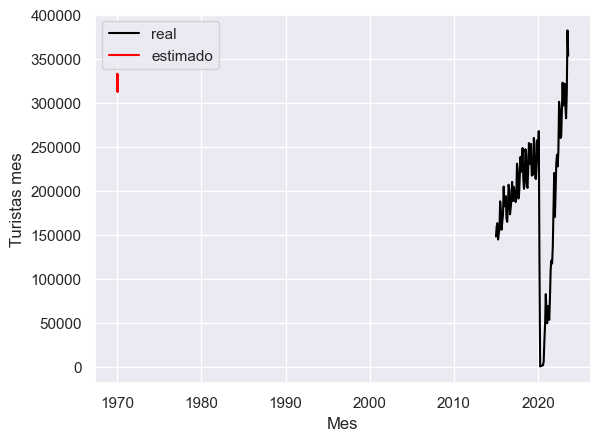

In [180]:
plt.plot(serie['Cantidad turistas'], color = "black", label = 'real')
plt.plot(y_pred_out['Predictions'], color = "red", label = 'estimado')
plt.legend()
plt.ylabel('Turistas mes')
plt.xlabel('Mes')
plt.show()